The basic idea is to use the labelled data in the SEAVIEW images to determine if the unsuperivsed classification algorithm is functioning in a desirable way.  For example, do all of the pixels with a particular class represent the same coral type?

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
!pwd

/Users/Mark/fruitpunch/coral_detection/notebooks


In [3]:
!ls ../data

14007262601.jpg                  34006105201.jpg
14007262601_colour_corrected.jpg 34008200601.jpg
14007262601_labels.png           annotations_PAC_AUS.csv
34006089701.jpg


In [4]:
image_path = '/Users/Mark/fruitpunch/coral_detection/data/'
image_file = '14007262601.jpg'

In [5]:
# colour correction using CLAHE algorithm

bgr = cv2.imread(image_path + image_file)

lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)

lab_planes = cv2.split(lab)

# clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
clahe = cv2.createCLAHE()

lab_planes[0] = clahe.apply(lab_planes[0])

lab = cv2.merge(lab_planes)

bgr_col_corr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

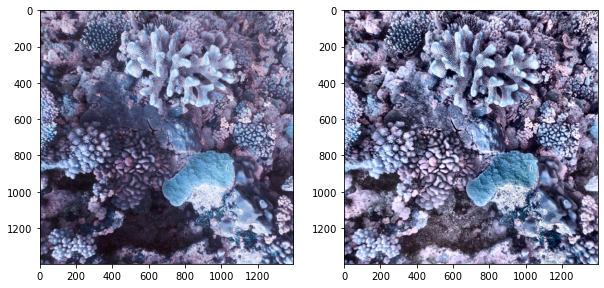

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(bgr);
ax[1].imshow(bgr_col_corr);

In [8]:
new_image = image_file.split('.')[0] + '_colour_corrected.' + image_file.split('.')[1]

In [9]:
plt.imsave(image_path + new_image, bgr_col_corr)
print("wrote: " + image_path + new_image)

wrote: /Users/Mark/fruitpunch/coral_detection/data/14007262601_colour_corrected.jpg


In [24]:
# run the segmentation algorithm
# https://github.com/kanezaki/pytorch-unsupervised-segmentation-tip

segmentation_script = "/Users/Mark/fruitpunch/coral_detection/pytorch-unsupervised-segmentation-tip/demo.py"
segmentation_options = "--nChannel 7 --maxIter 10 --visualize 1"

!python {segmentation_script} {segmentation_options} --input {image_path + new_image}

/Users/Mark/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
0 / 10 |  label num : 7  | loss : 2.1799848079681396
1 / 10 |  label num : 7  | loss : 1.6427640914916992
2 / 10 |  label num : 7  | loss : 1.4510667324066162
3 / 10 |  label num : 7  | loss : 1.3563729524612427
4 / 10 |  label num : 7  | loss : 1.3000787496566772
5 / 10 |  label num : 6  | loss : 1.270348072052002
6 / 10 |  label num : 6  | loss : 1.232105016708374
7 / 10 |  label num : 5  | loss : 1.181369423866272
8 / 10 |  label num : 5  | loss : 1.1228841543197632
9 / 10 |  label num : 5  | loss : 1.0624630451202393


In [26]:
# move output raster to data folder
!mv /Users/Mark/fruitpunch/coral_detection/notebooks/output.png /Users/Mark/fruitpunch/coral_detection/data/

In [27]:
# rename the output raster
image_labels = image_file.split('.')[0] + '_labels.png'
!mv /Users/Mark/fruitpunch/coral_detection/data/output.png {image_path + image_labels}

In [28]:
!ls ../data

14007262601.jpg                  34006105201.jpg
14007262601_colour_corrected.jpg 34008200601.jpg
14007262601_labels.png           annotations_PAC_AUS.csv
34006089701.jpg


Now read in the annotation file

In [29]:
annot_file = 'annotations_PAC_AUS.csv'

In [30]:
df = pd.read_csv(image_path + annot_file, index_col=0)

In [31]:
# choose only the rows corresponding to our image
id = os.path.basename(image_file).rstrip('.jpg')
id = int(id)
df = df.loc[id]

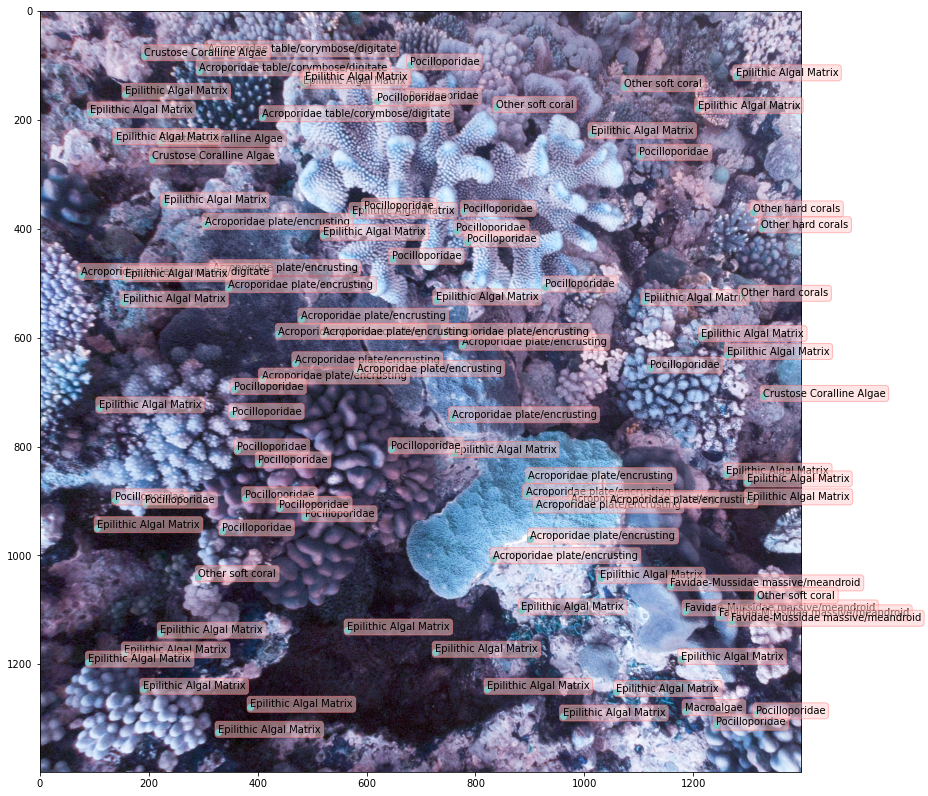

In [32]:
fig, ax = plt.subplots(1,1, figsize=(14,14))
ax.imshow(bgr);
ax.scatter(df["x"], df["y"], color="c");
for k, s in enumerate(df["label_name"]):
  x = df["x"].iloc[k]
  y = df["y"].iloc[k]
  plt.text(x, y, s, color='k', fontsize=10, 
           bbox=dict(boxstyle="round", 
                     ec=(1., 0.5, 0.5),
                     fc=(1., 0.8, 0.8),
                     alpha=0.5))

In [33]:
# read in the labels file.  the 0 flag means read into a single channel (instead of rgb)
lbls = cv2.imread(image_path + image_labels, 0)

In [34]:
np.unique(lbls)

array([ 80, 116, 118, 167, 246], dtype=uint8)

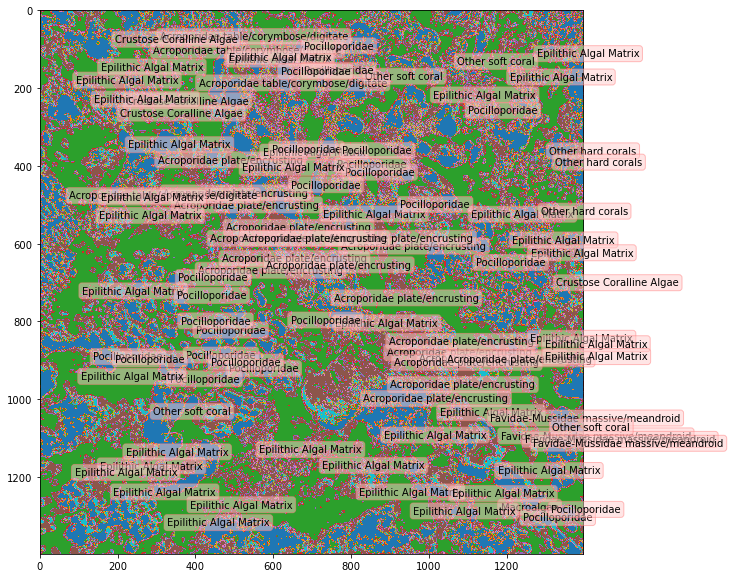

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(lbls, cmap=plt.get_cmap('tab10'))
for k,s in enumerate(df["label_name"]):
  x = df["x"].iloc[k]
  y = df["y"].iloc[k]
  plt.text(x, y, s, color='k', fontsize=10, 
           bbox=dict(boxstyle="round", 
                     ec=(1., 0.5, 0.5),
                     fc=(1., 0.8, 0.8),
                     alpha=0.5))

In [36]:
df['label_name'].unique()

array(['Acroporidae plate/encrusting',
       'Acroporidae table/corymbose/digitate', 'Crustose Coralline Algae',
       'Epilithic Algal Matrix', 'Favidae-Mussidae massive/meandroid',
       'Macroalgae', 'Other hard corals', 'Other soft coral',
       'Pocilloporidae'], dtype=object)

In [37]:
# setup a dictionary that contains all of the image x,y coordinates for each label name
coral_coords = dict.fromkeys(df['label_name'].unique().tolist())

for lbl in df['label_name'].unique():
    ind = df['label_name'] == lbl
    coral_coords[lbl] = df.loc[ind,('x','y')].to_numpy()

In [38]:
# initialize new column for the cluster number / classification
df['category'] = int(0)

In [39]:
# extract the unsupervised algorithm cluster number from each labelled pixel
for label_name, coords in coral_coords.items():
    x = coords[:,0]
    y = coords[:,1]
    classes = lbls[x, y]
    
    ind = df['label_name'] == label_name
    df.loc[ind,'category'] = classes

In [40]:
# count up hte occurences
data_to_plot = df.groupby(['label_name','category'], as_index=True)['category'].count()
data_to_plot

label_name                            category
Acroporidae plate/encrusting          80           4
                                      116          3
                                      118          1
                                      167          7
                                      246          4
Acroporidae table/corymbose/digitate  116          1
                                      118          1
                                      167          2
Crustose Coralline Algae              80           1
                                      116          1
                                      118          1
                                      167          1
Epilithic Algal Matrix                80           5
                                      116         15
                                      118          1
                                      167         15
                                      246          1
Favidae-Mussidae massive/meandroid    80           1

In [41]:
data_to_plot = data_to_plot.reset_index(level=['label_name'])
data_to_plot.rename(columns={'category':'count'}, inplace=True)
data_to_plot['class'] = data_to_plot.index
data_to_plot.reset_index(inplace=True, drop=True)

In [42]:
data_to_plot.head()

,label_name,count,class
0,Acroporidae plate/encrusting,4,80
1,Acroporidae plate/encrusting,3,116
2,Acroporidae plate/encrusting,1,118
3,Acroporidae plate/encrusting,7,167
4,Acroporidae plate/encrusting,4,246


In [43]:
coral_coords.keys()

dict_keys(['Acroporidae plate/encrusting', 'Acroporidae table/corymbose/digitate', 'Crustose Coralline Algae', 'Epilithic Algal Matrix', 'Favidae-Mussidae massive/meandroid', 'Macroalgae', 'Other hard corals', 'Other soft coral', 'Pocilloporidae'])

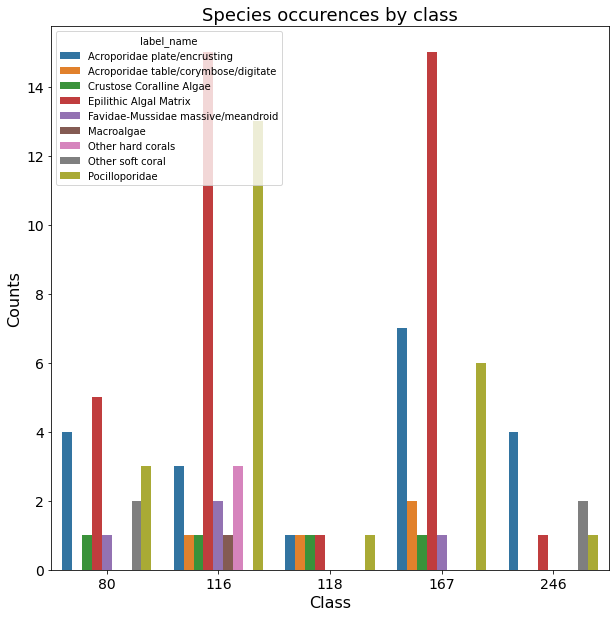

In [44]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.barplot(data=data_to_plot, x='class', y='count', hue='label_name', hue_order=list(coral_coords.keys()), ax=ax);
ax.set_title('Species occurences by class', size=18);
ax.set_ylabel('Counts',size=16);
ax.set_xlabel('Class', size=16);
ax.tick_params(labelsize=14);

In [45]:
np.unique(df['label_name'])

array(['Acroporidae plate/encrusting',
       'Acroporidae table/corymbose/digitate', 'Crustose Coralline Algae',
       'Epilithic Algal Matrix', 'Favidae-Mussidae massive/meandroid',
       'Macroalgae', 'Other hard corals', 'Other soft coral',
       'Pocilloporidae'], dtype=object)

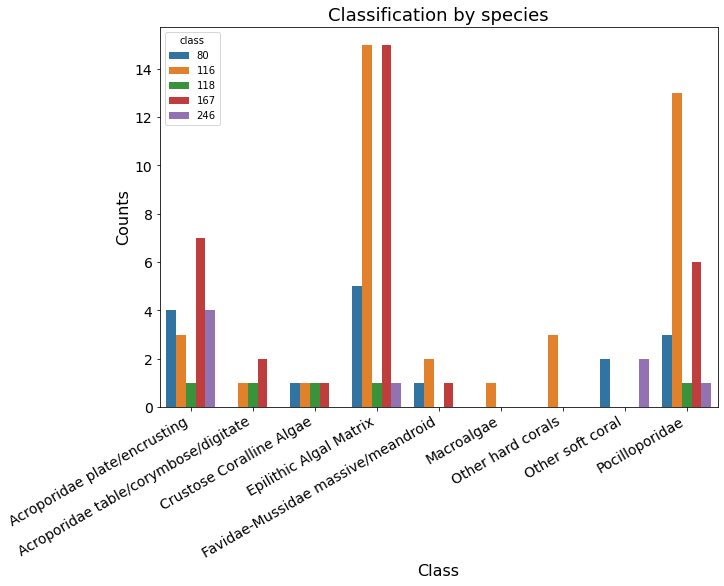

In [46]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.barplot(ax=ax, data=data_to_plot, x='label_name', y='count', hue='class', 
            hue_order=np.unique(data_to_plot['class']));
ax.set_title('Classification by species', size=18);
ax.set_ylabel('Counts',size=16);
ax.set_xlabel('Class', size=16);
ax.tick_params(labelsize=14);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right');

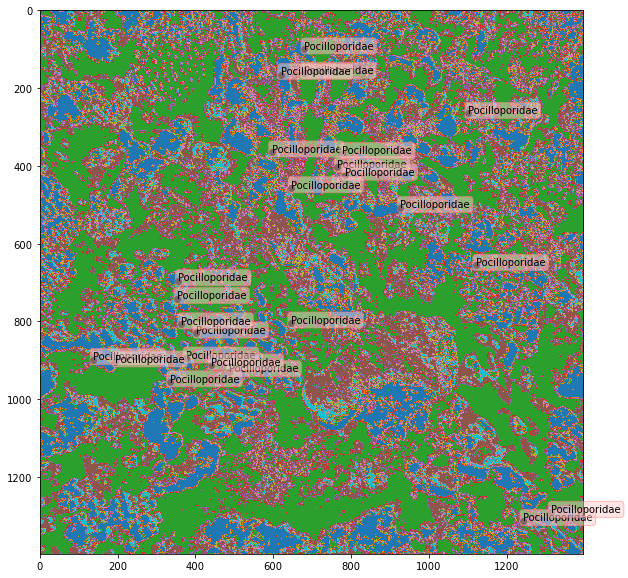

In [47]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(lbls, cmap=plt.get_cmap('tab10'))
ax.scatter(coral_coords['Pocilloporidae'][:,0], coral_coords['Pocilloporidae'][:,1],c='k')
for x, y in coral_coords['Pocilloporidae']:
    plt.text(x, y, 'Pocilloporidae', color='k', fontsize=10, 
             bbox=dict(boxstyle="round", 
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       alpha=0.5))

In [50]:
df['func_group'].unique()

array(['Hard Coral', 'Algae', 'Soft Coral'], dtype=object)

In [55]:
ind = df['func_group'] == 'Algae'
ind = ind | (df['label_name'] == 'Epilithic Algal Matrix')
df.loc[ind,['label_name','func_group']]

,label_name,func_group
quadratid,,
14007262601,Crustose Coralline Algae,Algae
14007262601,Crustose Coralline Algae,Algae
14007262601,Crustose Coralline Algae,Algae
14007262601,Crustose Coralline Algae,Algae
14007262601,Epilithic Algal Matrix,Algae
14007262601,Epilithic Algal Matrix,Algae
14007262601,Epilithic Algal Matrix,Algae
14007262601,Epilithic Algal Matrix,Algae
14007262601,Epilithic Algal Matrix,Algae
